In [1]:
import numpy as np
import matplotlib.pyplot as plt

from signal_tl import Signal, Predicate, compute_robustness, F, G
from signal_tl.plot import plot_robustness, plot_trace, plot_negative_span

plt.rcParams['figure.figsize'] = [10, 4]

In [2]:
# Hyperparameters

time_step = 0.1
duration = 7
n_cp = 5  # should be above 3 (due to differential operation)

In [3]:
# utils

def pick_n_dividing_points(target: np.ndarray, n: int) -> np.ndarray:
    q = len(target) / n
    idx = [int(np.floor(i * q)) for i in range(n)]
    return target[idx]


def generate_diff_signals(
    symbol: str, control_points, valuation, times, max_deriv_order=0):
    def nth_deriv(n):
        if n<= 0:
            values = np.interp(times, control_points, valuation)
        else:
            diff = np.diff(valuation, n=n) 
            values = np.interp(times, control_points[:-n], diff)
        return Signal(values, times)
    return {
        (symbol + "'" * i): nth_deriv(i) 
        for i in range(max_deriv_order + 1)
    }


def eq(predicate, value):
    epsilon = 1e-3
    return (predicate > value - epsilon) & (predicate < value + epsilon)

In [4]:
# Signal generation

def generate_trace(control_points, sampled_point, times):
    valuation_x = sampled_point[:len(control_points)]
    valuation_y = sampled_point[len(control_points):]
    xs = generate_diff_signals("x", control_points, valuation_x, times, max_deriv_order=3)
    ys = generate_diff_signals("y", control_points, valuation_y, times, max_deriv_order=3)
    return {
        **xs,
        **ys,
        "y - x": Signal(np.array(ys["y"].values) - np.array(xs["x"].values), times),
    }

time_series = np.arange(0, duration, time_step)
control_points = pick_n_dividing_points(time_series, n_cp)
search_dim = len(control_points) * 2

# sample = 10 * np.random.default_rng().random(search_dim)
# trace0 = generate_trace(control_points, sample, time_series)
# plot_trace(trace0, "trace0", sharey=False, figsize=[10, 14])

In [5]:
# Spec definition

danger = (Predicate("y - x") < 10)
carx = ((Predicate("x'") > 5) & (Predicate("x'") < 27) & 
        (Predicate("x''") > -3) & (Predicate("x''") < 3) &
        (Predicate("x'''") > -5) & (Predicate("x'''") < 5))
cary = ((Predicate("y'") > 5) & (Predicate("y'") < 27) & 
        (Predicate("y''") > -3) & (Predicate("y''") < 3) &
        (Predicate("y'''") > -5) & (Predicate("y'''") < 5))

sim = (eq(Predicate("x"), 0) & eq(Predicate("y"), 45) & 
        F(danger, (0, 7)) & 
        G(carx & cary & (Predicate("y - x") > 0))
)

In [6]:
import numpy as np
from cmaes import CMA
import time

optimizer = CMA(mean=np.zeros(search_dim), sigma=1.3)

history = []
falsified_traces = []
generation = 0

t1 = time.time()

while len(falsified_traces) < 5:
    solutions = []
    for _ in range(optimizer.population_size):
        x = optimizer.ask()
        trace = generate_trace(control_points, x, time_series)
        value = compute_robustness(~sim, trace).at(0)
        history.append(trace)
        if value < 0:
            falsified_traces.append(trace)
            print(f"#{generation} {value} (x1={x[0]}, x2 = {x[1]})")
        solutions.append((x, value))
    optimizer.tell(solutions)

    generation += 1

elapsed = time.time() - t1

#215 -0.0005066618467241886 (x1=0.0004933381532758114, x2 = 11.750030939874415)
#220 -0.0003739109408513741 (x1=0.00019889390710271663, x2 = 11.785647622081372)
#228 -0.00012163982867008372 (x1=-0.0003582722110426588, x2 = 11.713723629697824)
#234 -0.0003600503768923719 (x1=0.0006399496231076281, x2 = 11.758910459045099)
#236 -0.0004019958642373922 (x1=3.4637530896110616e-06, x2 = 11.740086190954385)


In [7]:
elapsed

0.8095431327819824

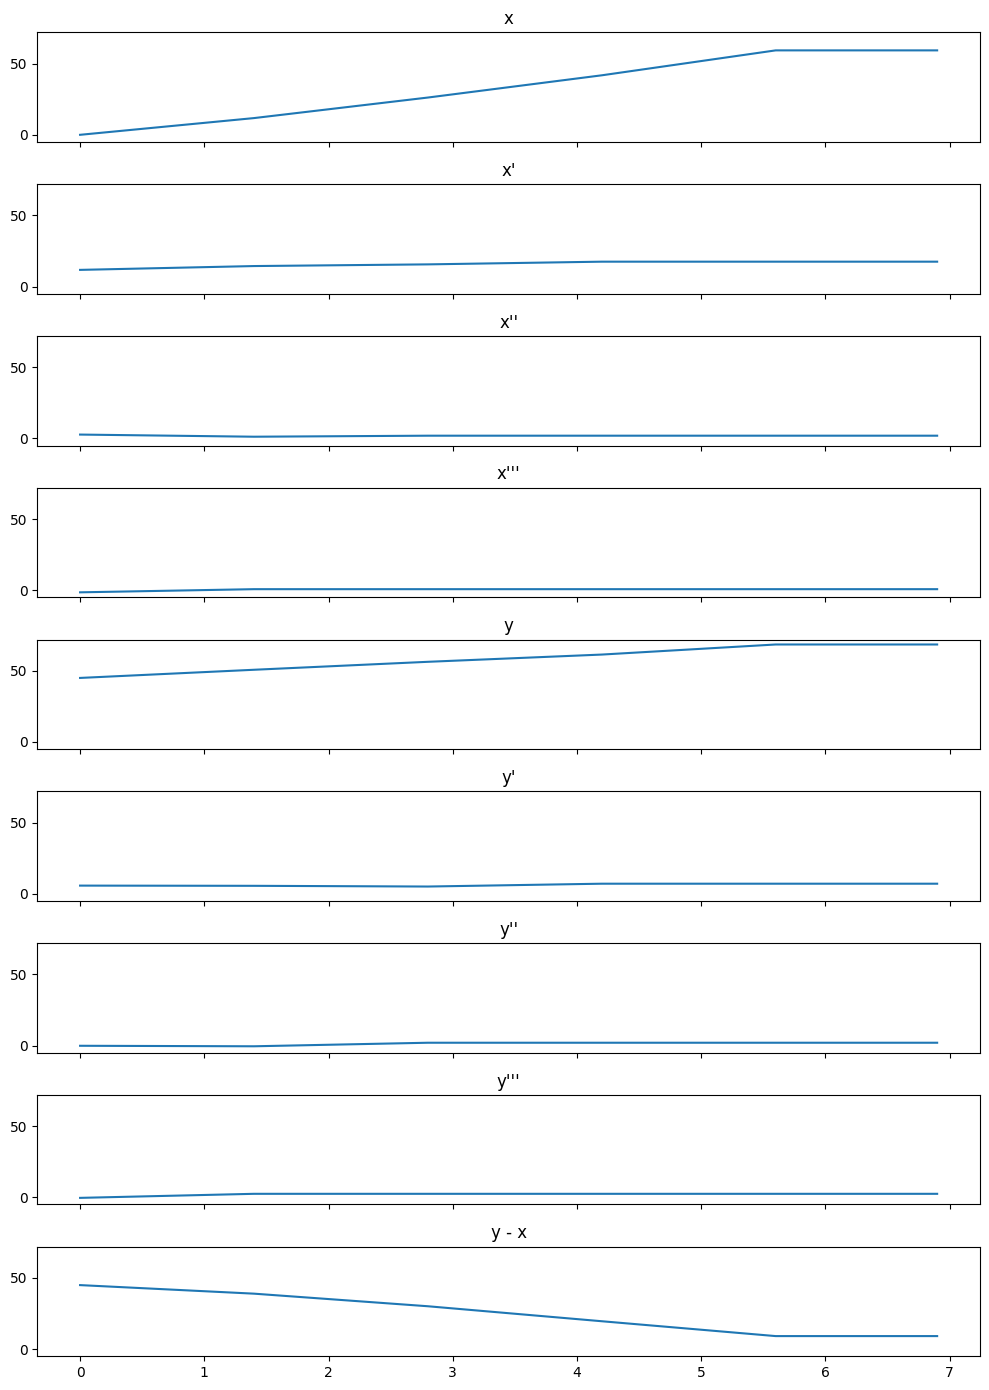

In [8]:
# Show best signal

results = falsified_traces if len(falsified_traces) != 0 else history[:-5]

plot_trace(results[0], figsize=[10, 14])

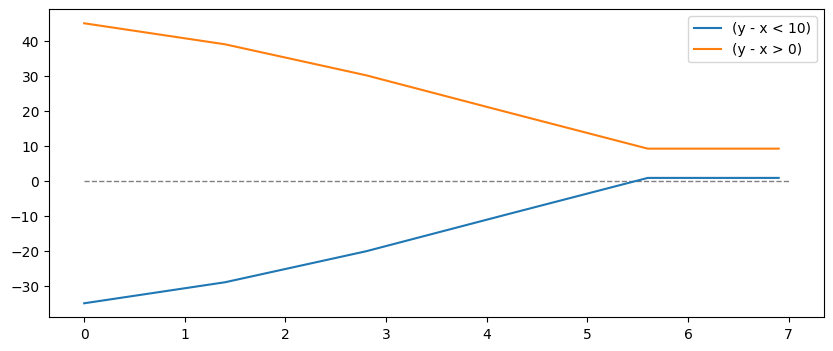

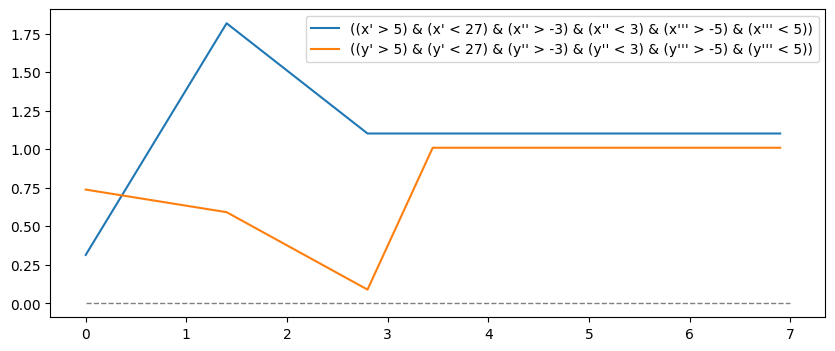

In [9]:
# plot some subformulas

plt.hlines(0, 0, duration, color='gray', linestyle='--', linewidth=1)
plot_robustness(danger, results[0])
plot_robustness((Predicate("y - x") > 0), results[0])
plt.legend()
plt.show()

plt.hlines(0, 0, duration, color='gray', linestyle='--', linewidth=1)
plot_robustness(carx, results[0])
plot_robustness(cary, results[0])
plt.legend()
plt.show()

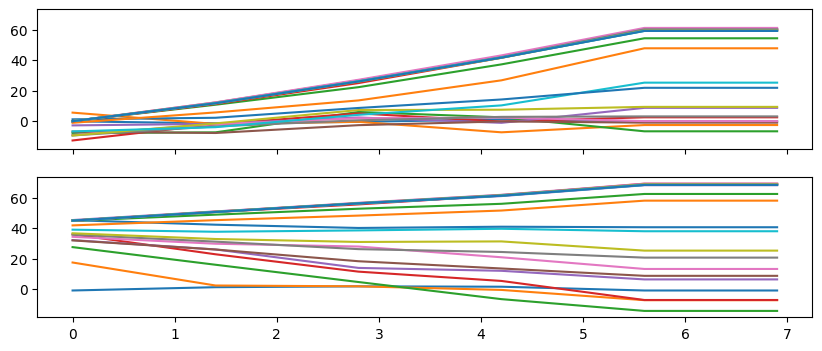

In [10]:
# show some (5%) of all generated signals

def plot_traces_xy(traces, **figure_args):
    fig, ax = plt.subplots(2, sharex=True, sharey=True, **figure_args)
    for trace in traces:
        ax[0].plot(trace["x"].times, trace["x"].values)
        ax[1].plot(trace["y"].times, trace["y"].values)

plot_traces_xy(history[::len(history)//20])